Load the data

In [1]:
import os 
os.getcwd()

'/home/ayan/research/us_location_identifier/src'

In [2]:
import pandas as pd


In [3]:
 
df = pd.read_csv('../data/users_with_locations.csv.gz',compression='gzip')
df_en = pd.read_csv('../data/featureEngineered/users_with_locations_sm.csv.gz',compression='gzip')


In [4]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
# look at all the column types 
df_en.dtypes


reviewer_profile      object
bio_language          object
lang_id1               int64
lang_id2               int64
lang_id3               int64
lang_id4               int64
lang_id5               int64
lang_id6               int64
lang_id7               int64
lang_id8               int64
lang_id9               int64
lang_id10              int64
lang_id11              int64
lang_id12              int64
lang_id13              int64
lang_id14              int64
lang_id15              int64
lang_id16              int64
lang_id17              int64
lang_id18              int64
lang_id19              int64
lang_id20              int64
lang_id21              int64
lang_id22              int64
lang_id23              int64
lang_id24              int64
lang_id25              int64
lang_id26              int64
lang_id27              int64
lang_id28              int64
lang_id29              int64
lang_id30              int64
lang_id31              int64
lang_id32              int64
lang_id33     

In [5]:
# Set higher but reasonable limits
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
df_en['bio_language'].head()

0    en
1    no
2    en
3    en
4    en
Name: bio_language, dtype: object

Need to drop columns I cannot use for modellings. - name, reviewer profile, full bio probably spacy location, metadata, bio_language

In [6]:
#remove the non required columns and save the deleted ones in a new dataframe so we can merge them later
df_removed = df_en[['reviewer_profile','bio_language','name','metadata','full_bio','spacy_location']]
df_en = df_en.drop(['bio_language','name','metadata','full_bio','spacy_location'], axis=1)



df_en.head()

,reviewer_profile,lang_id1,lang_id2,lang_id3,lang_id4,lang_id5,lang_id6,lang_id7,lang_id8,lang_id9,lang_id10,lang_id11,lang_id12,lang_id13,lang_id14,lang_id15,lang_id16,lang_id17,lang_id18,lang_id19,lang_id20,lang_id21,lang_id22,lang_id23,lang_id24,...,medium,vsco,anilist,soundcloud,musicboard,pinterest,albumoftheyear,anchorfm,beacons,wikipedia,behance,skoob,substack,bitly,podcastsapplecom,patreon,google,biosite,threadsnet,has_location,location_us,engl_can_spelling,bio_len,num_urls,spacy_us_location
0,000000000000111,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,286,0,0.0
1,0001yo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,20,0,0.0
2,00036g,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,34,1,0.0
3,0005itstime,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,51,0,0.0
4,000777,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,13,0,0.0


In [7]:
df_removed.head()

,reviewer_profile,bio_language,name,metadata,full_bio,spacy_location
0,000000000000111,en,Owl From Louisiana ✝️,Laputa,Just a completely insane man with completely i...,nil
1,0001yo,no,iyo,he/him,i love my girlfriend,nil
2,00036g,en,Hannah Leimberger,Austria;instagram.com : https://www.instagram....,personal archive and public diary.,nil
3,0005itstime,en,0005itstime,vie the capital,my top 4 basically just sum up who I am as a p...,nil
4,000777,en,cande,argentina,hater a veces,nil


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


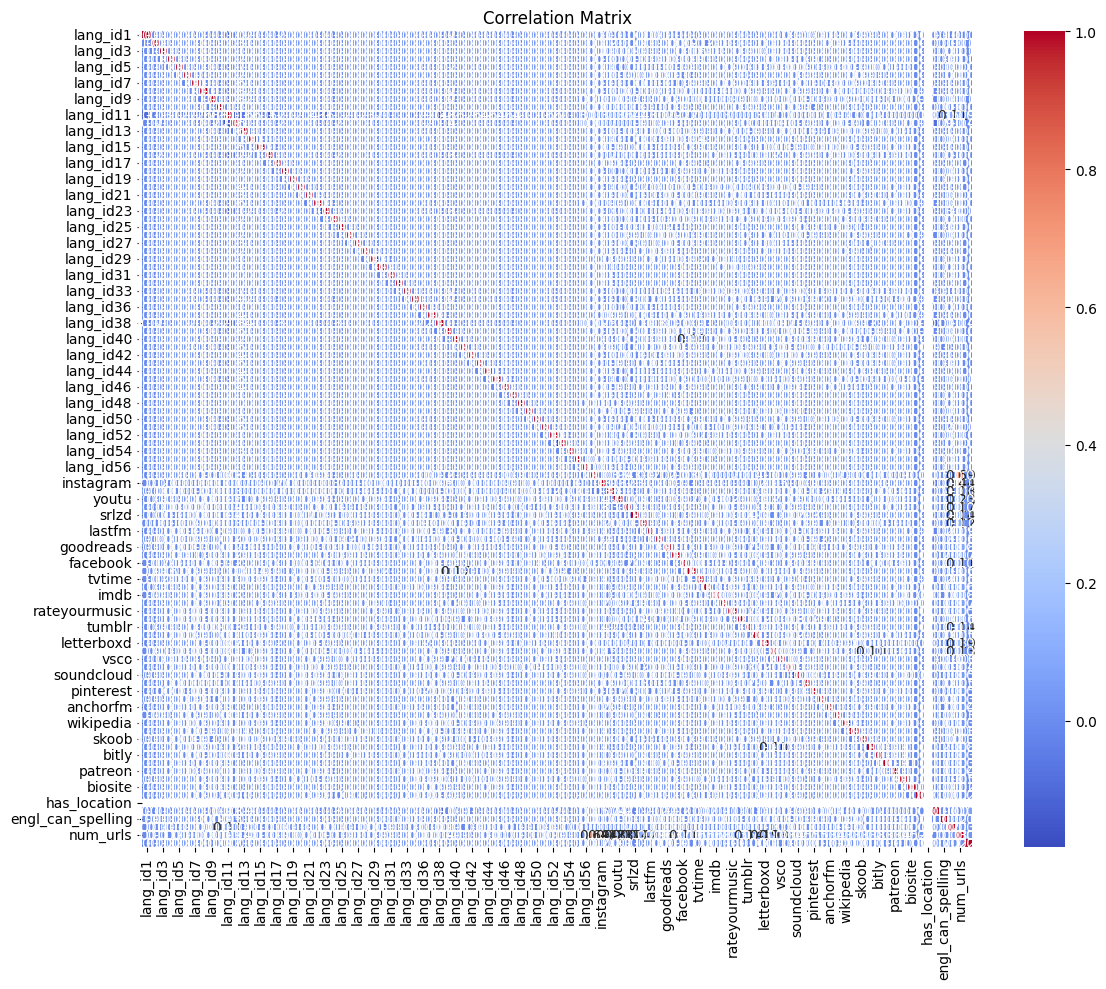

In [10]:
%pip install matplotlib
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
# check correlation b/w feature variables - ignoring reviewer_profile
columns_for_corr = [col for col in df_en.columns if col != 'reviewer_profile']
cm = df_en[columns_for_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



obviosuly too many vartiables - will use PCA to reduce dimensionality.